## Preprocessing Primary Dataset

## 1. Import Libraries

In [4]:
import os
import json
from PIL import Image
import random
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Unzip Dataset

This is a primary dataset. We collect these photos of Indonesian nutrition label products from our phones or the internet. After that, we cropped every text from those images and successfully created more than 2000 images

In [5]:
# Remove directory if exists for a clean start
if os.path.exists("data/dataset ocr per frasa"):
    shutil.rmtree("data/dataset ocr per frasa")

In [6]:
# Unzip the dataset
with zipfile.ZipFile("../../../data_raw/primer/dataset ocr per frasa.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [7]:
# Define a converter function for the value column
def format_percentage(value):
    if isinstance(value, (float, int)) and 0 <= value <= 1:
        return f"{value * 100:.0f}%"  # Convert decimal to percentage string
    return str(value)  #Keep other values as strings

# Read the Excel file and apply the converter
data = pd.read_excel('data/dataset ocr per frasa/labeled_dataset.xlsx', converters={"value": format_percentage})
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2021 non-null   int64 
 1   value   2021 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.7+ KB


,id,value
0,0,INFORMASINILAIGIZI
1,1,INFORMASINILAIGIZI
2,2,TotalCalories
3,3,CaloriesfromFat
4,4,Natrium
...,...,...
2016,2016,90mg
2017,2017,20%
2018,2018,10%
2019,2019,3%


## 3. Data Preprocessing

We will create dataset folder structure below for both train_set & val_set:

```shell
├── images
    ├── 0.jpg
    ├── 1.jpg
    ├── 2.jpg
    └── ...
├── labels.json
```

labels.json structure:

```shell 
{
    "0.jpg": "I",
    "1.jpg": "am",
    "2.jpg": "a",
    "3.jpg": "Jedi",
    "4.jpg": "100%",
    ...
}
```

In [8]:
# Source and destination paths
source_path = "data/dataset ocr per frasa"
destination_path = os.path.join(source_path, "dataset_cleaned")

# Paths for new folders and files
train_images_path = os.path.join(destination_path, "train_set", "images")
val_images_path = os.path.join(destination_path, "val_set", "images")
train_labels_path = os.path.join(destination_path, "train_set", "labels.json")
val_labels_path = os.path.join(destination_path, "val_set", "labels.json")

# Create new folders
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)

The model will accept up to 32 characters of the label. We will skip some images if those labels are more than 32 characters

In [9]:
# Split data 90:10
image_ids = data['id'].tolist()
random.shuffle(image_ids)
train_size = int(len(image_ids) * 0.9)
train_ids = image_ids[:train_size]
val_ids = image_ids[train_size:]

# Function to copy and convert images
def process_images(ids, src_folder, dst_folder, labels):
    for img_id in ids:
        label = str(data.loc[data['id'] == img_id, 'value'].values[0]).replace(" ", "")  # Remove spaces from label
        if len(label) > 32:
            continue  # Skip images with labels longer than 32 characters

        src_image_path = os.path.join(src_folder, f"{img_id}.png")
        dst_image_path = os.path.join(dst_folder, f"{img_id}.jpg")

        # Convert PNG to JPG and copy
        with Image.open(src_image_path) as img:
            rgb_img = img.convert("RGB")
            rgb_img.save(dst_image_path, format="JPEG")

        # Add label
        labels[f"{img_id}.jpg"] = label

# Prepare dictionary for labels
train_labels = {}
val_labels = {}

# Process train and val images
process_images(train_ids, os.path.join(source_path, "dataset"), train_images_path, train_labels)
process_images(val_ids, os.path.join(source_path, "dataset"), val_images_path, val_labels)

# Save labels to JSON file
with open(train_labels_path, "w") as f:
    json.dump(train_labels, f, indent=4)

with open(val_labels_path, "w") as f:
    json.dump(val_labels, f, indent=4)

# Print dataset information
print(f"Dataset has been successfully processed and saved in the folder: {destination_path}")
print(f"Number of training samples: {len(train_labels)}")
print(f"Number of validation samples: {len(val_labels)}")

# Calculate min and max length of label values
train_label_lengths = [len(value) for value in train_labels.values()]
val_label_lengths = [len(value) for value in val_labels.values()]

print(f"Training labels - Min length: {min(train_label_lengths)}, Max length: {max(train_label_lengths)}")
print(f"Validation labels - Min length: {min(val_label_lengths)}, Max length: {max(val_label_lengths)}")

Dataset has been successfully processed and saved in the folder: data/dataset ocr per frasa\dataset_cleaned
Number of training samples: 1798
Number of validation samples: 200
Training labels - Min length: 1, Max length: 32
Validation labels - Min length: 2, Max length: 32


In [7]:
# Print mmin width, max width, min height, max height of images from training set
train_image_widths = []
train_image_heights = []

for img_id in train_labels.keys():
    with Image.open(os.path.join(train_images_path, img_id)) as img:
        width, height = img.size
        train_image_widths.append(width)
        train_image_heights.append(height)
        
print(f"Training images - Min width: {min(train_image_widths)}, Max width: {max(train_image_widths)}")
print(f"Training images - Min height: {min(train_image_heights)}, Max height: {max(train_image_heights)}")

Training images - Min width: 13, Max width: 678
Training images - Min height: 10, Max height: 48


In [8]:
# Print mmin width, max width, min height, max height of images from validation set
val_image_widths = []
val_image_heights = []

for img_id in val_labels.keys():
    with Image.open(os.path.join(val_images_path, img_id)) as img:
        width, height = img.size
        val_image_widths.append(width)
        val_image_heights.append(height)
        
print(f"Validation images - Min width: {min(val_image_widths)}, Max width: {max(val_image_widths)}")
print(f"Validation images - Min height: {min(val_image_heights)}, Max height: {max(val_image_heights)}")

Validation images - Min width: 23, Max width: 363
Validation images - Min height: 11, Max height: 44


## 4. Data Visualization

In [9]:
def visualize_samples(image_folder, labels, num_samples=9):
    sample_ids = random.sample(list(labels.keys()), num_samples)
    fig, axes = plt.subplots(3, 3, figsize=(11,6))
    for i, ax in enumerate(axes.flat):
        img = Image.open(os.path.join(image_folder, sample_ids[i]))
        ax.imshow(np.array(img))
        ax.set_title(labels[sample_ids[i]])
        ax.axis("off")
    fig.suptitle("Image samples", fontsize=16)
    plt.tight_layout()
    plt.show()

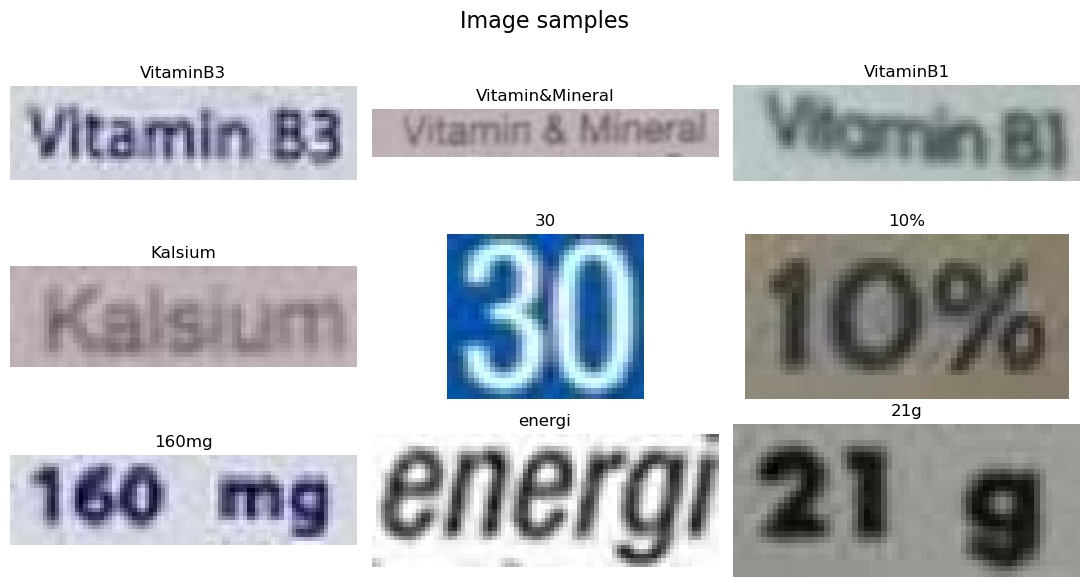

In [17]:
# Visualize some samples from the training set
visualize_samples(train_images_path, train_labels)

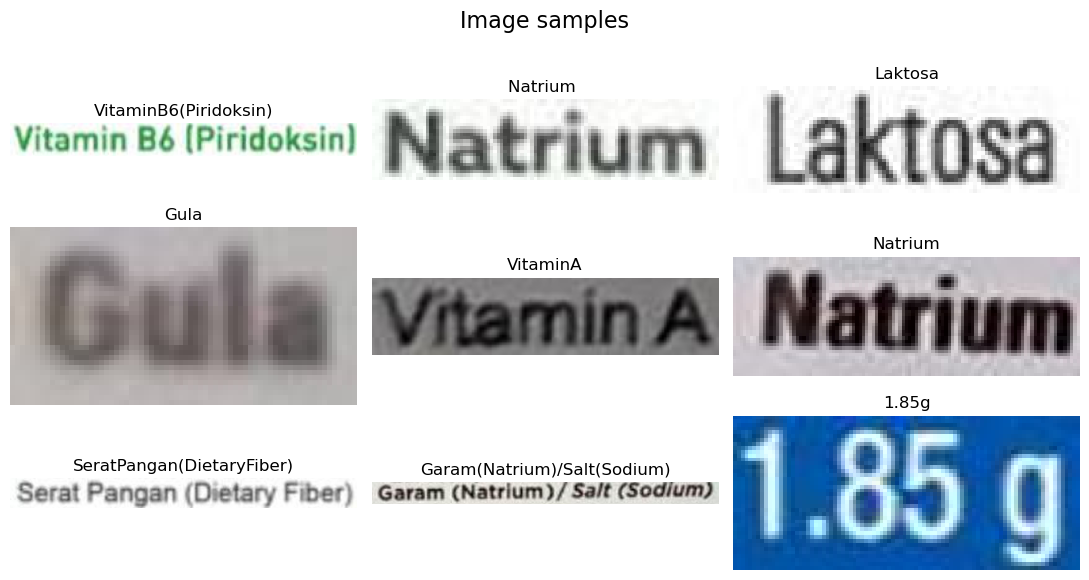

In [18]:
# Visualize some samples from the validation set
visualize_samples(val_images_path, val_labels)

## 4. Fine Tuning

We will use pretained CRNN with MobileNet_v3 model based on docTR training script


The docTR library (short for "Document Text Recognition") is an open-source Python library developed to handle tasks related to document text detection and recognition. It is specifically designed to process scanned documents, PDFs, and images containing text. The library uses state-of-the-art deep learning models to identify text regions and extract text efficiently.

It also provide pretained model and can be fine tuned for specific dataset

In [10]:
# Download docTR script for Model Training and Evaluation
!curl -L -o doctr-0.6.0.zip https://github.com/mindee/doctr/archive/refs/tags/v0.6.0.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  435k    0  435k    0     0   445k      0 --:--:-- --:--:-- --:--:--  445k


In [11]:
# Unzip the downloaded script
with zipfile.ZipFile("doctr-0.6.0.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

The documentation about how to use docTR script for training text recognition model can be found in this [GitHub link](https://github.com/mindee/doctr/tree/main/references/recognition#readme)

The detail about docTR Library can be found in [this website](https://mindee.github.io/doctr/v0.6.0/using_doctr/custom_models_training.html)

In [ ]:
# Train the model using this command
# All the detail about how this command works can be found in the docTR documentation
!python 'doctr-0.6.0/references/recognition/train_pytorch.py' crnn_mobilenet_v3_large --train_path 'data/dataset ocr per frasa/dataset_cleaned/train_set' --val_path 'data/dataset ocr per frasa/dataset_cleaned/val_set' --epochs 20 --pretrained --font helvetica --max-chars 32  --device 0

^C


## 5. Fine Tune Result

After running 20 epoch we got val_loss 0.11275 on the last epoch and val_loss 0.110184 on the optimal weight epoch. The script is automatically save the best weight.

![Last Epoch Result](last_epoch_result.png)

![Optimal Weight Result](optimal_weight_result.png)